In [1]:
import pandas as pd
import numpy as np
import torch
from phd import get_phd
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import modeling_utils
if not hasattr(modeling_utils, "ALL_PARALLEL_STYLES") or modeling_utils.ALL_PARALLEL_STYLES is None:
    modeling_utils.ALL_PARALLEL_STYLES = ["tp", "none", "colwise", 'rowwise']


model_name = "Qwen/Qwen3-0.6B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)



class AddDeleteWordAnalyzer:
    def __init__(self, tokenizer, number_of_texts=3, number_of_words_per_text=15, n_tries=10):
        self.tokenizer = tokenizer
        self.number_of_texts = number_of_texts
        self.number_of_words_per_text = number_of_words_per_text
        self.n_tries = n_tries

    def delete_word(self, texts):
        word2diff_phd = dict()
        for _ in tqdm(range(self.number_of_texts)): # 40
            print(len(texts))
            text = texts[np.random.choice(len(texts))]
            tokenized = tokenizer(text)['input_ids'][1:-1]
            df_example = pd.DataFrame({'text': [text]})
            true_phd = get_phd(df_example)[0][0]
            entropies = self.get_entropy_of_text(text)
            
            for i in np.random.choice(len(tokenized), size=self.number_of_words_per_text): # 10
                new_text = tokenizer.decode(tokenized[:i] + tokenized[i + 1:])# ' '.join(tokenized[:i] + tokenized[i + 1:])
                df_new = pd.DataFrame({'text': [new_text]})
                new_phd = get_phd(df_new, n_tries=self.n_tries)[0][0]
                word2diff_phd[tokenized[i]] = true_phd - new_phd, text, entropies[i]
            
        df_stats2 = pd.DataFrame(pd.Series(word2diff_phd), columns=['diff_phd']).sort_values(by='diff_phd')
        return df_stats2

    def get_entropy_of_text(self, text):
        inputs = self.tokenizer(text, return_tensors="pt")
        output = model(**inputs)
        probs = torch.softmax(output.logits.float(), dim=1)
        raw_entropy = -(probs * torch.log(probs)).detach().data.sum(axis=-1)
        result = list(
            zip(
                raw_entropy.reshape(-1).tolist(),
                [tokenizer.decode([token_id]) for token_id in inputs['input_ids'].reshape(-1)]
            )
        )
        return result

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
df = pd.read_parquet("data/train-00000-of-00009.parquet")
analyzer = AddDeleteWordAnalyzer(tokenizer)
human_texts = df.query("model == 'human'")['generation'].values.tolist()
llm_texts = df.query("model != 'human'")['generation'].values.tolist()

,id,adv_source_id,source_id,model,decoding,repetition_penalty,attack,domain,title,prompt,generation
350603,8fd99316-3e9d-4ff5-9e9d-53b0a8afd869,b1b2e17c-b8e8-41dc-8b51-b737c9b36fbc,b1b2e17c-b8e8-41dc-8b51-b737c9b36fbc,human,None,None,zero_width_space,abstracts,Studying the Plasticity in Deep Convolutional ...,None,R​e​c​e​n​t​l​y​ ​t​h​e​r​e​ ​h​a​s​ ​b​e​e​n​...
13114,79171045-dc71-449b-acd4-8265ffefa6ca,79171045-dc71-449b-acd4-8265ffefa6ca,79171045-dc71-449b-acd4-8265ffefa6ca,human,None,None,none,abstracts,Time complexity of Synchronization of discrete...,None,A major open question in the study of synchron...
98879,2d1203cf-4fe9-4d56-87cc-2b5823ca50c2,ddf19e58-1ca3-4b1f-a706-84991950857a,ddf19e58-1ca3-4b1f-a706-84991950857a,human,None,None,number,abstracts,Affinity Fusion Graph-based Framework for Natu...,None,This paper proposes an affinity fusion graph f...
94839,99dc89ee-dc5f-4ebf-af0d-04e3ef69c6df,f0231dbc-5d7f-498f-a58f-a29168af6ecd,f0231dbc-5d7f-498f-a58f-a29168af6ecd,human,None,None,number,abstracts,Dispersion modeling and analysis for multilaye...,None,This paper presents a detailed modeling and an...
20113,ae9b93ca-d464-47d0-ba02-ec5d59498a30,140f34a5-4ea1-484f-a361-9351c81fd864,140f34a5-4ea1-484f-a361-9351c81fd864,human,None,None,whitespace,abstracts,The Data Complexity of Description Logic Ontol...,None,We analyze the data complexity of ontology-med...
434066,3ffc2e91-f319-493f-aa6f-f41f2002c291,073dda0d-b651-42ac-a6f5-0cd3f0831d2c,073dda0d-b651-42ac-a6f5-0cd3f0831d2c,human,None,None,upper_lower,books,All the Pretty Horses,None,"The novel Tells Of John Grady Cole, a sixteen ..."
433961,638c4265-ef62-434c-b8c7-f44046562b2d,c414a329-4595-4aab-9535-d198b3f74824,c414a329-4595-4aab-9535-d198b3f74824,human,None,None,upper_lower,books,No Telephone to Heaven,None,The Novel begins with a small group of guerill...
24391,276b4408-55fc-4169-9288-4496e08c56bb,73f1466c-623d-46fe-a0a5-1bb3b3af5f86,73f1466c-623d-46fe-a0a5-1bb3b3af5f86,human,None,None,whitespace,abstracts,Deep Learning and Its Applications to Machine ...,None,"Since 2006, deep learning (DL) has become a ra..."
409754,420e6da7-97b2-43f6-b197-cc12fc7cf736,fc0e4d8f-b140-4dba-a2e4-a0b96b25ae95,fc0e4d8f-b140-4dba-a2e4-a0b96b25ae95,human,None,None,whitespace,books,Joker in the pack,None,The novel describes the student life of Shekha...
66421,8aa2e111-eb69-4044-ba57-30427ba4aaa1,86592658-6b55-4a6f-a35b-384baaf28609,86592658-6b55-4a6f-a35b-384baaf28609,human,None,None,perplexity_misspelling,abstracts,Meta Corrupted Pixels Mining for Medical Image...,None,Deep neural networks have achieved satisfactor...


In [8]:
human_phd_new = get_phd(df.query("model == 'human'").sample(30), 'generation', n_tries=10)

100%|███████████████████████████████████████████| 30/30 [04:04<00:00,  8.15s/it]


In [5]:
llm_phd = get_phd(df.query("model != 'human'").sample(30), 'generation', n_tries=10)

100%|███████████████████████████████████████████| 30/30 [04:15<00:00,  8.53s/it]


array([[<Axes: title={'center': '0'}>]], dtype=object)

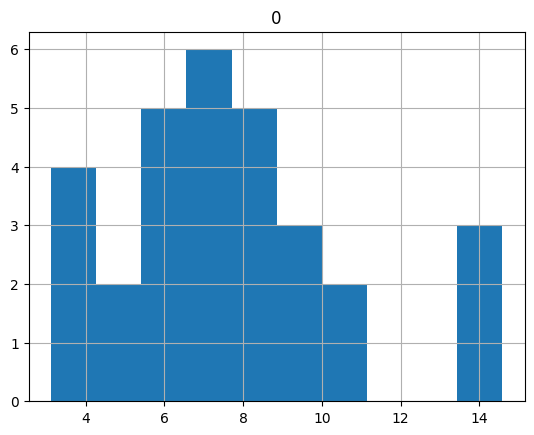

In [9]:
pd.DataFrame(llm_phd).hist(bins=10)

In [11]:
pd.DataFrame(llm_phd).mean()

0    7.636599
dtype: float64

0    8.394199
dtype: float64

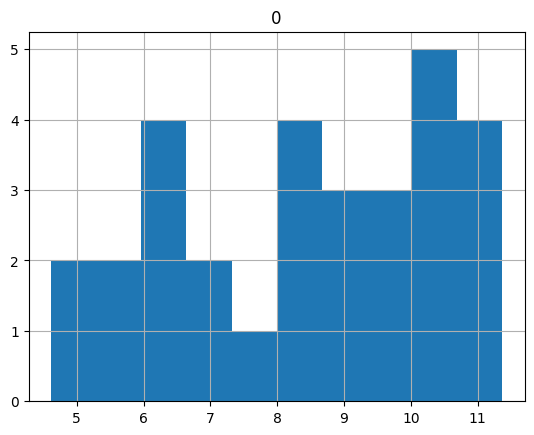

In [13]:
_ = pd.DataFrame(human_phd_new).hist()
pd.DataFrame(human_phd_new).mean()

In [ ]:
d